In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
annonimized = pd.read_csv("annonimized.csv") 
th_public = pd.read_csv("th-public.csv")  

In [3]:
column_mapping = {
    "concat('it001',`assignment_id`)": "assignment_id",
    "concat('it001',`problem_id`)": "problem_id",
    "concat('it001', username)": "username",
    "is_final": "is_final",
    "status": "status",
    "pre_score": "pre_score",
    "coefficient": "coefficient",
    "concat('it001',`language_id`)": "language_id",
    "created_at": "created_at",
    "updated_at": "updated_at",
    "judgement": "judgement"
}

column_mapping_th = {
    "hash": "username",
    "TH": "TH"
}

annonimized.rename(columns=column_mapping, inplace=True)
th_public.rename(columns=column_mapping_th, inplace=True)

In [4]:
problem_count_per_assignment = annonimized.groupby('assignment_id')['problem_id'].count().reset_index()
problem_count_per_assignment.rename(columns={'problem_id': 'total_problem_count'}, inplace=True)

assignment_count_per_user = annonimized.groupby('username')['assignment_id'].count().reset_index()
assignment_count_per_user.rename(columns={'assignment_id': 'total_assignment_count'}, inplace=True)

annonimized = annonimized.merge(problem_count_per_assignment, on='assignment_id', how='left')
annonimized = annonimized.merge(assignment_count_per_user, on='username', how='left')

status_mapping = {
    'SCORE': 0,
    'Compilation Error': 1,
    'Syntax Error': 2,
    'pending': 3
}

if 'status' in annonimized.columns:
    annonimized['status_normalized'] = annonimized['status'].map(status_mapping)

In [5]:
grouped_data = annonimized.groupby('username').agg({
    'assignment_id': lambda x: '|'.join(map(str, x.unique())),  
    'problem_id': lambda x: '|'.join(map(str, x.unique())),     
    'pre_score': 'mean',  
    'coefficient' : 'mean' , 
    'status_normalized' : 'sum', 
    'judgement': lambda x: '|'.join(map(str, x.unique())),  
    'total_problem_count': 'first',  
    'total_assignment_count': 'first'  
}).reset_index()
grouped_data

,username,assignment_id,problem_id,pre_score,coefficient,status_normalized,judgement,total_problem_count,total_assignment_count
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,d0204dbfca44b08e0f01a0d9c70de22d7b270d91|2e12f...,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff|7a6e5...,5504.149660,100.000000,28,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",321,147
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,e575df7d08a0629b70ca925cc05be3929d41f417|03c6c...,789454427dd4097a14749e3dde63346b7a8d3811|d6a5b...,5488.552124,100.000000,50,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd...",2049,259
2,01122b3ef7e59b84189e65985305f575d6bdf83c,2332134902d353a36a50c66b072a8253ed3f8755|1bec7...,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff|7a6e5...,5973.753846,100.000000,20,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",212,195
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,d5372d90cbe05cb77c15a26cba512ef2f73e8c28|9ccbb...,789454427dd4097a14749e3dde63346b7a8d3811|bf96f...,5952.760000,100.000000,24,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",1280,100
4,013de369c439ab0ead8aa7da64423aa395a8be39,dbd5858a976c702c1710f4fb4baa57a64d7dd346|d3b9b...,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff|7a6e5...,6474.448598,97.196262,13,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2057,107
...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,16e29978d00b41ae746603560176e34022252f5f|5c1a8...,1f61beedbeee4445960a90ee18d8fc0c21201eef|d2a85...,5581.081081,100.000000,3,"{""times"":[0,0],""mems"":[0,0],""verdicts"":[]}|{""t...",55,74
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,66395be77e9e0ae16cb96fb66f677d824e743227|fdb39...,6ade33982bda90847f53eb141f3ef23d5cbee0f7|bf96f...,6204.557692,100.000000,44,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",1768,260
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,2811b037082e27292e4f103efe932b30b3b5b0fe|b3d87...,217ba7563116dab9ca8bf00875e14cec255d7525|f86c7...,4998.466819,100.000000,77,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2356,437
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,590cf6459bdae1e4327f25c1d1ea9c145d496054|3425a...,8b15ab090e1e8ec3284cf78746d94ffa00bd201b|7a6e5...,4343.329787,100.000000,20,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd...",7114,94


In [6]:
grouped_data = grouped_data.merge(th_public[['username', 'TH']], on='username', how='left')

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def encode_column(col):
    return col.apply(lambda x: len(set(x.split('|'))))  

grouped_data.loc[:, 'assignment_id'] = encode_column(grouped_data['assignment_id'])
grouped_data.loc[:, 'problem_id'] = encode_column(grouped_data['problem_id'])
grouped_data.loc[:, 'judgement'] = encode_column(grouped_data['judgement'])

In [8]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   username                1489 non-null   object 
 1   assignment_id           1489 non-null   object 
 2   problem_id              1489 non-null   object 
 3   pre_score               1489 non-null   float64
 4   coefficient             1489 non-null   float64
 5   status_normalized       1489 non-null   int64  
 6   judgement               1489 non-null   object 
 7   total_problem_count     1489 non-null   int64  
 8   total_assignment_count  1489 non-null   int64  
 9   TH                      755 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 116.5+ KB


['5' '8.5' '7' nan '10' '6' '7.5' '8' '5.5' '9' '6.5' '9.5' '4.5' '4'
 '2.5' '3.5' '1' '1.5' '2' '0.5' '3' '\xa0']


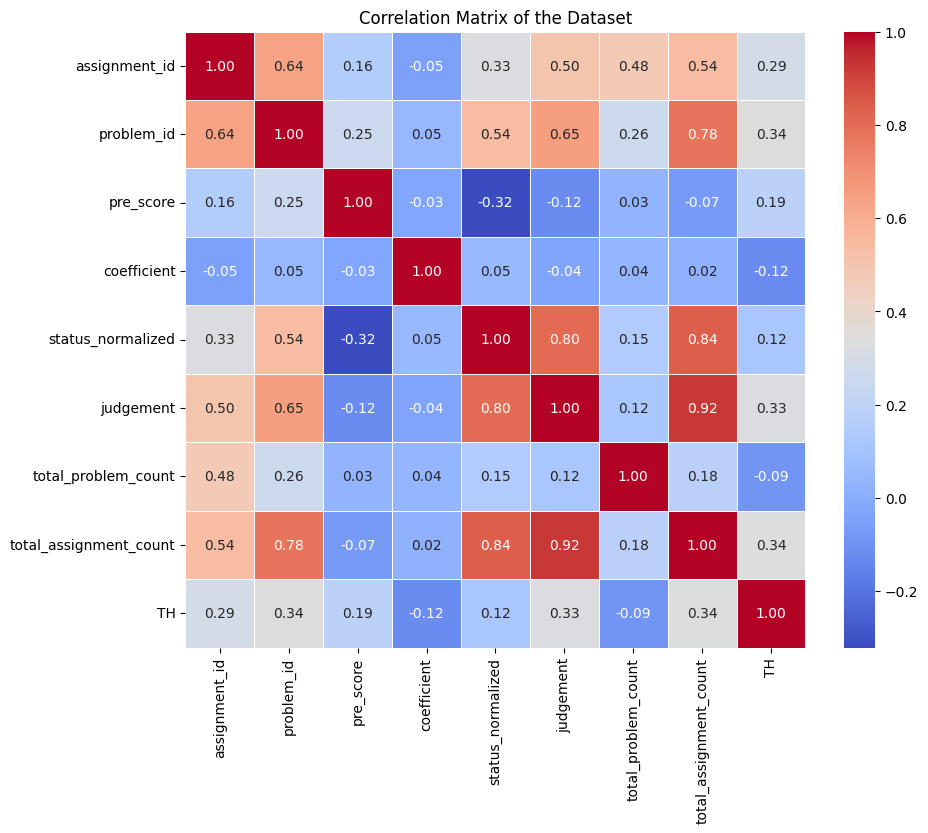

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

print(grouped_data['TH'].unique())  
grouped_data['TH'] = grouped_data['TH'].replace({'\xa0': 0, '': 0}, regex=True)  
grouped_data['TH'] = grouped_data['TH'].astype(float) 

grouped_data['assignment_id'] = pd.to_numeric(grouped_data['assignment_id'], errors='coerce') 
grouped_data['problem_id'] = pd.to_numeric(grouped_data['problem_id'], errors='coerce') 
grouped_data['judgement'] = pd.to_numeric(grouped_data['judgement'], errors='coerce') 

train_data_new = grouped_data.copy()

train_data_new['TH'] = pd.to_numeric(train_data_new['TH'], errors='coerce')

correlation_matrix = train_data_new.drop(columns="username").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')
plt.show()

- Nhận xét độ tương quan của các cột với cột TH
- Nếu tương quan mạnh gần tiến về 1 hoặc -1 thì mô hình mạnh
- Nếu tương quan yếu gần về 0 thì mô hình yếu

In [10]:
train_data = grouped_data.dropna(subset=['TH']).copy()

features = ['assignment_id', 'problem_id', 'pre_score', 'judgement', 'total_assignment_count','total_problem_count' , 'coefficient' , 'status_normalized']

X = train_data[features]
y = train_data['TH']

y = y.replace({'\xa0': 0, '': 0}, regex=True)  
y = y.astype(float)  

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()

model.fit(X_train, y_train)

GradientBoostingRegressor()

In [12]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = ((y_test - y_pred) ** 2).mean()

print(f"Đánh giá hiệu năng mô hình:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Đánh giá hiệu năng mô hình:
Mean Absolute Error (MAE): 1.2643
R-squared (R²): 0.5044
Mean Squared Error (MSE): 2.4269


In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

model = GradientBoostingRegressor()

model.fit(X, y)

GradientBoostingRegressor()

In [14]:
data_to_predict = grouped_data[grouped_data['TH'].isna()]

X_to_predict = data_to_predict[features]
data_to_predict.loc[:, 'TH'] = model.predict(X_to_predict)

In [15]:
output = data_to_predict[['username', 'TH']]

output['TH'] = output['TH'].astype(float).round(2)

output

C:\Users\Admin\AppData\Local\Temp\ipykernel_12400\3392019374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['TH'] = output['TH'].astype(float).round(2)


,username,TH
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,5.26
20,035f97702f2c01d26ab1fae8f39ea2f98a0caa3c,7.04
40,06024da8147b5cf6105beb4c403f67cf1ff0aea1,8.38
68,0aaebc88f6106684d6993c156104c1ef36cf94e0,5.68
80,0bf111a9caedf02804f6991792490e63bc21058a,8.47
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,8.06
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,8.10
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,7.11
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,3.51


In [16]:
output.to_csv("predicted_th_for_new_users.csv", index=False, header=False)

print("Kết quả dự đoán đã được lưu vào predicted_th_for_new_users.csv")

Kết quả dự đoán đã được lưu vào predicted_th_for_new_users.csv
